In [1]:
import os
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager

import utils.globals as globals

fm = matplotlib.font_manager.json_load("./fontlist-v330.json")
fm.findfont("serif", rebuild_if_missing=False)
fm.findfont("serif", fontext="afm", rebuild_if_missing=False)

plt.rcParams.update({
    'text.usetex': False, 
    'font.family': 'serif', 
    'font.serif': ['Times New Roman'], 
    'font.size': 14, 
})

c:\Users\Willi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


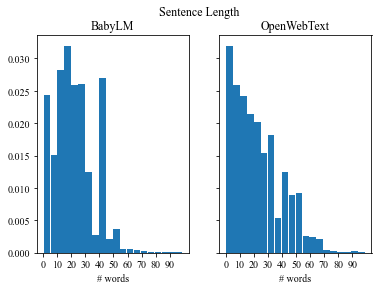

In [2]:
# Pre-experiment
# Sentence length distribution
def counts_to_list(counts, cutoff=100):
    out = []
    for key, val in counts.items():
        if int(key) > cutoff:
            continue
        for _ in range(val):
            out.append(key)
    df = pd.DataFrame({
        '# Words': out
    })
    return df

with open('../data/subsampled/sent_len_counts.json', 'r') as f:
    counts_babylm = json.load(f)
    counts_babylm = counts_to_list(counts_babylm)

with open('../data/subsampled/sent_len_counts_openwebtext_dist.json', 'r') as f:
    counts_openwebtext = json.load(f)
    counts_openwebtext = counts_to_list(counts_openwebtext)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(counts_babylm['# Words'], bins=20, rwidth=0.95, density=True)
ax2.hist(counts_openwebtext['# Words'], bins=20, rwidth=0.95, density=True)

ax1.set_xticks(ticks=np.arange(0, 100, step=10), labels=np.arange(0, 100, step=10))
ax1.set_xlabel('# words')
ax1.set_title('BabyLM')

ax2.set_xticks(ticks=np.arange(0, 100, step=10), labels=np.arange(0, 100, step=10))
ax2.set_xlabel('# words')
ax2.set_title('OpenWebText')

plt.suptitle('Sentence Length')

plt.savefig('./figs/sentence_length.pdf', dpi=200)

plt.show()

In [15]:
# Get a list of overall syneval accuracy
def get_syneval_total_acc(path):
    with open(path, 'r') as f:
        data = json.load(f)
    
    checkpoint_iters = sorted([int(key.split('-')[-1]) for key in data.keys()])
    checkpoint_head = '-'.join([key.split('-')[:-1] for key in data.keys()][0])
    
    accs = []
    checkpoint_iters_out = []
    for iter in checkpoint_iters:
        if iter >= 130000:
            continue
        k = f'{checkpoint_head}-{iter}'
        acc = aggregate_acc(data[k])
        accs.append(acc)
        checkpoint_iters_out.append(iter)

    return checkpoint_iters_out, accs

def aggregate_acc(data):
    total_n_test = 0
    for val in data.values():
        for v in val.values():
            # total_n_test += v[1] # micro average
            total_n_test += 1 # macro average

    out = 0
    for val in data.values():
        for v in val.values():
            # out += v[0] * v[1] / total_n_test
            out += v[0] / total_n_test
    return out

# get_syneval_total_acc(f'{globals.OUT_DIR}/babylm_100M-poc_syneval.json')
    

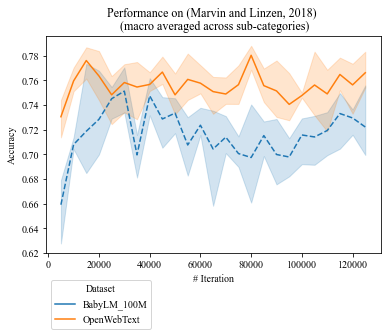

In [20]:
# Plot the aggreageed result on syn_eval over time
def get_aggregated_dfs(path_groups):
    out = {
        '# Iteration': [],
        'Accuracy': [],
        'Dataset': []
    }
    for path_group_name, path_group in path_groups.items():
        for path in path_group:
            iters, accs = get_syneval_total_acc(f'{globals.OUT_DIR}/{path}_syneval.json')
            for i in range(len(iters)):
                out['# Iteration'].append(iters[i])
                out['Accuracy'].append(float(accs[i]))
                out['Dataset'].append(path_group_name)
    df = pd.DataFrame(out)
    return df

path_groups = {
    'BabyLM_100M': ['babylm_100M-poc', 'babylm_100M-poc1', 'babylm_100M-poc2'],
    'OpenWebText': ['openwebtext-poc', 'openwebtext-poc1', 'openwebtext-poc2']
}
df = get_aggregated_dfs(path_groups)

ax = sns.lineplot(data = df, x = '# Iteration', y = 'Accuracy', hue = 'Dataset')
ax.lines[0].set_linestyle("--")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, -0.1))
plt.title('Performance on (Marvin and Linzen, 2018) \n (macro averaged across sub-categories)')
plt.savefig('./figs/syneval overall.pdf', dpi=300)


In [14]:
def eval_sub_cat(data):
    out = {}
    for d, subs in data.items():
        accs = []
        for val in subs.values():
            accs.append(val[0])
        out[d] = sum(accs) / len(accs)
    return out
    
def shrink_cats(group_out):

    out = {
        'Simple': group_out['simple_agrmt'],
        'In a sentential complement': group_out['sent_comp'],
        'Short VP coordination': group_out['vp_coord'],
        'Long VP coordination': group_out['long_vp_coord'],
        'Across a prepositional phrase ': (group_out['prep_inanim'] + group_out['prep_anim']) / 2,
        'Across a subject relative clause': group_out['subj_rel'],
        'Across an object relative clause': (group_out['obj_rel_across_inanim'] + group_out['obj_rel_across_anim']) / 2,
        'Across an object relative (no that)': (group_out['obj_rel_no_comp_across_inanim'] + group_out['obj_rel_no_comp_across_anim']) / 2,
        'In an object relative clause': (group_out['obj_rel_within_inanim'] + group_out['obj_rel_within_anim']) / 2,
        'In an object relative (no that)': (group_out['obj_rel_no_comp_within_inanim'] + group_out['obj_rel_no_comp_within_anim']) / 2,
        
        'Anaphora_Simple': group_out['simple_reflexives'],
        'Anaphora_In a sentential complement': group_out['reflexive_sent_comp'],
        'Across a relative clause': group_out['reflexives_across'],

        'NPI_Simple': (group_out['simple_npi_inanim'] + group_out['simple_npi_anim']) / 2,
        'Across a relative clause': (group_out['npi_across_inanim'] + group_out['npi_across_anim']) / 2,
    } 
    agg = []
    for acc in out.values():
        agg.append(acc)
    out['Macro Average'] = sum(agg) / len(agg)
    return out

def aggregate_sub_cat(path_groups):
    out = {}
    for path_group_name, path_group in path_groups.items():
        group_out = {}
        for path in path_group:
            with open(f'{globals.OUT_DIR}/{path}_syneval.json', 'r') as f:
                data = json.load(f)[f'../results/model_checkpoints/{path}/checkpoint-40000']
                evaled = eval_sub_cat(data)
                for cat, acc in evaled.items():
                    if cat not in group_out.keys():
                        group_out[cat] = 0
                    group_out[cat] += acc / len(path_group)
        out[path_group_name] = shrink_cats(group_out)
    return out

aggregate_sub_cat(path_groups)

{'BabyLM_100M': {'Simple': 0.8952380952380954,
  'In a sentential complement': 0.8634920634920635,
  'Short VP coordination': 0.9023809523809523,
  'Long VP coordination': 0.8225,
  'Across a prepositional phrase ': 0.760787037037037,
  'Across a subject relative clause': 0.699375,
  'Across an object relative clause': 0.7934540343915344,
  'Across an object relative (no that)': 0.680613425925926,
  'In an object relative clause': 0.8244047619047619,
  'In an object relative (no that)': 0.7795089285714285,
  'Anaphora_Simple': 0.9476190476190476,
  'Anaphora_In a sentential complement': 0.8671626984126983,
  'Across a relative clause': 0.5438715277777778,
  'NPI_Simple': 0.32546296296296295,
  'Macro Average': 0.7647050382653061},
 'OpenWebText': {'Simple': 0.911904761904762,
  'In a sentential complement': 0.8509920634920636,
  'Short VP coordination': 0.8936507936507936,
  'Long VP coordination': 0.8491666666666666,
  'Across a prepositional phrase ': 0.7479662698412699,
  'Across a 

<ipython-input-4-ba4a1b377dab>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
<ipython-input-4-ba4a1b377dab>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original_hit = df.loc[df['type'] == 'original'][df['class'] == 'correct'][df['preds'] == 1]
<ipython-input-4-ba4a1b377dab>:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen = df.loc[df['type'] == 'generated'][df['class'] == 'correct']
<ipython-input-4-ba4a1b377dab>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gen_hit = df.loc[df['type'] == 'generated'][df['class'] == 'correct'][df['preds'] == 1]
<ipython-input-4-ba4a1b377dab>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
<ipython-input-4-ba4a1b377dab>:12: UserWarning: B

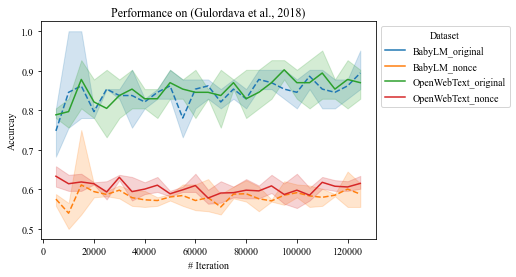

In [4]:
# Aggregated plot for colorless green
iters, acc, ds = [], [], []
dirs = ['../results/outputs/babylm_100M-poc/sva',
        '../results/outputs/babylm_100M-poc1/sva',
        '../results/outputs/babylm_100M-poc2/sva']
for dir in dirs:
    for iter in range(5000, 130000, 5000):
        path = f'{dir}/checkpoint-{iter}.csv'
        df = pd.read_csv(path)
        
        original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
        original_hit = df.loc[df['type'] == 'original'][df['class'] == 'correct'][df['preds'] == 1]

        gen = df.loc[df['type'] == 'generated'][df['class'] == 'correct']
        gen_hit = df.loc[df['type'] == 'generated'][df['class'] == 'correct'][df['preds'] == 1]

        iters.append(iter)
        acc.append(len(original_hit)/len(original))
        ds.append('BabyLM_original')

        iters.append(iter)
        acc.append(len(gen_hit)/len(gen))
        ds.append('BabyLM_nonce')

dirs = ['../results/outputs/openwebtext-poc/sva',
       '../results/outputs/openwebtext-poc1/sva',
       '../results/outputs/openwebtext-poc2/sva']

for dir in dirs:
    for iter in range(5000, 130000, 5000):
        path = f'{dir}/checkpoint-{iter}.csv'
        df = pd.read_csv(path)
        
        original = df.loc[df['type'] == 'original'][df['class'] == 'correct']
        original_hit = df.loc[df['type'] == 'original'][df['class'] == 'correct'][df['preds'] == 1]

        gen = df.loc[df['type'] == 'generated'][df['class'] == 'correct']
        gen_hit = df.loc[df['type'] == 'generated'][df['class'] == 'correct'][df['preds'] == 1]

        iters.append(iter)
        acc.append(len(original_hit)/len(original))
        ds.append('OpenWebText_original')

        iters.append(iter)
        acc.append(len(gen_hit)/len(gen))
        ds.append('OpenWebText_nonce')

df = pd.DataFrame({
    '# Iteration': iters,
    'Accurcay': acc,
    'Dataset': ds
})

ax = sns.lineplot(data = df, x = '# Iteration', y = 'Accurcay', hue = 'Dataset')
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Performance on (Gulordava et al., 2018)')
plt.savefig('./figs/colorless green.png', dpi=200)